<a href="https://colab.research.google.com/github/orhbulu/repo/blob/master/Transfer_Learning_Ship_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transfer Learning for ships and CNN
Dataset from https://www.kaggle.com/arpitjain007/ship-classification/

In [0]:
%tensorflow_version 2.x

In [0]:
!nvidia-smi

Fri Apr 10 00:12:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import tensorflow as tf

import tensorflow.keras
from tensorflow.keras.applications.inception_v3 import InceptionV3, decode_predictions, preprocess_input #importing InceptionV3
from tensorflow.keras.applications.nasnet import NASNetMobile, preprocess_input, decode_predictions #importing NASNetMobile
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions #importing Inception_ResNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image as keras_preprocessing_image
from tensorflow.keras.utils import plot_model

import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import time

## Importing Ship Dataset using pandas and classifying the categories

In [0]:
import os
print(os.listdir("../content/drive/My Drive/Colab Notebooks/Ship/train"))

['images', 'train.csv']


In [0]:
rcsv= pd.read_csv("../content/drive/My Drive/Colab Notebooks/Ship/train/train.csv")
data_path = "../content/drive/My Drive/Colab Notebooks/Ship/train/images/"
image_files = [ os.path.join(data_path, f) for f in os.listdir(data_path) 
                 if (f.lower().endswith('png') or f.lower().endswith('jpg')) 
                 and f!='logo.png' ]

In [0]:
Category = ['Null','Cargo', 'Carrier', 'Cruise', 'Military', 'Tankers']
#Dataset consists of classifier 1 to 5. Inputting Null as placeholder

In [0]:
rcsv.size

12504

Sample CSV Data

In [0]:
for i in range(0,10):
  print(rcsv.iloc[i][0], rcsv.iloc[i][1])

2823080.jpg 1
2870024.jpg 1
2662125.jpg 2
2900420.jpg 3
2804883.jpg 2
621252.jpg 4
2833467.jpg 1
2843780.jpg 5
2859567.jpg 3
2896557.jpg 1


In [0]:
def image_to_input(model, img_path):
    target_size=model.input_shape[1:]
    img = keras_preprocessing_image.load_img(img_path, target_size=target_size)

    x = keras_preprocessing_image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    return x

In [0]:
def get_single_prediction(img_path, top, test_model):
    x = image_to_input(test_model, img_path)
    preds = test_model.predict(x)
    predictions = decode_predictions(preds, top=top)
    return predictions[0]

Cropping function

In [0]:
def crop_middle_square_area(np_image):
    h, w, _ = np_image.shape
    h = int(h/2)
    w = int(w/2)
    if h>w:
        return np_image[ h-w:h+w, : ]
    return np_image[ :, w-h:w+h ]    

# Testing on 1 sample with 3 different models

In [0]:
model_NASnet = NASNetMobile(weights='imagenet', include_top=True)
model_IncepV3 = InceptionV3(weights='imagenet', include_top=True)
model_IncepResnet = InceptionResNetV2(weights='imagenet', include_top=True)

225214464/225209952 [==============================] - 4s 0us/step


NASNet


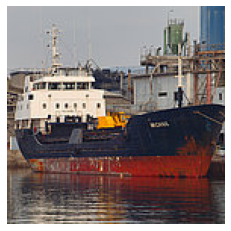

40960/35363 [==================================] - 0s 0us/step
  0.82 dock
  0.05 container_ship
  0.02 liner
  0.01 drilling_platform
  0.01 breakwater
Inception V3


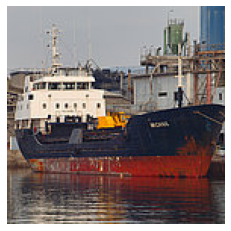

  0.76 dock
  0.04 drilling_platform
  0.04 liner
  0.03 wreck
  0.03 container_ship
InceptionResNet


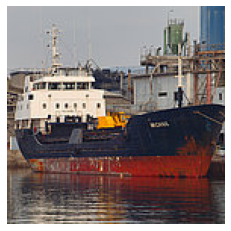

  0.73 dock
  0.20 container_ship
  0.01 liner
  0.00 submarine
  0.00 drilling_platform


In [0]:
img_path = image_files[1]
im = plt.imread(img_path)
print('NASNet')
plt.figure()
plt.axis('off')
im = crop_middle_square_area(im)
plt.imshow(im)
plt.show()
for t in get_single_prediction(img_path,5,model_NASnet):
  print("%6.2f %s" % (t[2],t[1],))
#NASnet

plt.figure()
plt.axis('off')
print('Inception V3')
plt.imshow(im)
plt.show()
for t in get_single_prediction(img_path,5,model_IncepV3):
  print("%6.2f %s" % (t[2],t[1],))
#InceptionV3

plt.figure()
plt.axis('off')
print('InceptionResNet')
plt.imshow(im)
plt.show()
for t in get_single_prediction(img_path,5,model_IncepResnet):
  print("%6.2f %s" % (t[2],t[1],))
#InceptionResNetV2

## Transfer Learning for 3 different models, without top

In [0]:
NAS_model_logits   = NASNetMobile(weights='imagenet', include_top=False, pooling=None)
Incep3_model_logits   = InceptionV3(weights='imagenet', include_top=False, pooling=None)
IncepRes_model_logits   = InceptionResNetV2(weights='imagenet', include_top=False, pooling=None)

219062272/219055592 [==============================] - 2s 0us/step


In [0]:
def get_logits_from_non_top(np_logits):
    # ~ average pooling
    #return np_logits[0].sum(axis=0).sum(axis=0)
    
    # ~ max-pooling
    return np_logits[0].max(axis=0).max(axis=0)

# Training the dataset (NASNet)

In [0]:
train = dict(filepath=[], features=[], target=[])
data_path = "../content/drive/My Drive/Colab Notebooks/Ship/train/images/"
t0 = time.time()

for i in range(0,2500): #enumerate(rcsv.values):
  training_images_path = os.path.join(data_path, rcsv.iloc[i][0])
  x = image_to_input(NAS_model_logits, training_images_path)
  np_logits_pooled = NAS_model_logits.predict(x)
  np_logits_pooled = get_logits_from_non_top( np_logits_pooled )
        
  train['filepath'].append(training_images_path)
  train['features'].append(np_logits_pooled)
  train['target'].append( rcsv.iloc[i][1] )

print("DONE : %6.2f seconds each" %(float(time.time() - t0)/len(train),))

DONE :  53.33 seconds each


In [0]:
from sklearn import svm
classifier = svm.LinearSVC()
classifier.fit(train['features'], train['target']) # learn from the data 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

# Training the dataset (Inception V3)

In [0]:
train2 = dict(filepath=[], features=[], target=[])
data_path = "../content/drive/My Drive/Colab Notebooks/Ship/train/images/"
t0 = time.time()

for i in range(0,2500): #enumerate(rcsv.values):
  training_images_path = os.path.join(data_path, rcsv.iloc[i][0])
  x = image_to_input(model_IncepV3, training_images_path)
  np_logits_pooled2 = Incep3_model_logits.predict(x)
  np_logits_pooled2 = get_logits_from_non_top( np_logits_pooled2 )
        
  train2['filepath'].append(training_images_path)
  train2['features'].append(np_logits_pooled2)
  train2['target'].append( rcsv.iloc[i][1] )

print("DONE : %6.2f seconds each" %(float(time.time() - t0)/len(train),))

DONE :  38.40 seconds each


In [0]:
from sklearn import svm
classifier2 = svm.LinearSVC()
classifier2.fit(train2['features'], train2['target']) # learn from the data 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

# Training the dataset (Inception-ResNet-v2)

In [0]:
train3 = dict(filepath=[], features=[], target=[])
data_path = "../content/drive/My Drive/Colab Notebooks/Ship/train/images/"
t0 = time.time()

for i in range(0,2500): #enumerate(rcsv.values):
  training_images_path = os.path.join(data_path, rcsv.iloc[i][0])
  x = image_to_input(model_IncepResnet, training_images_path)
  np_logits_pooled3 = IncepRes_model_logits.predict(x)
  np_logits_pooled3 = get_logits_from_non_top( np_logits_pooled3 )
        
  train3['filepath'].append(training_images_path)
  train3['features'].append(np_logits_pooled3)
  train3['target'].append( rcsv.iloc[i][1] )

print("DONE : %6.2f seconds each" %(float(time.time() - t0)/len(train),))

DONE :  62.33 seconds each


In [0]:
from sklearn import svm
classifier3 = svm.LinearSVC()
classifier3.fit(train3['features'], train3['target']) # learn from the data 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

# Classifying Test Set (NASNet)

DONE :   0.74 seconds each


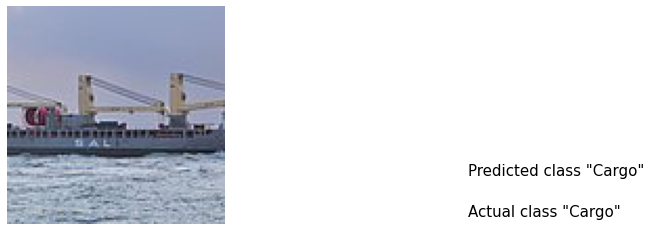

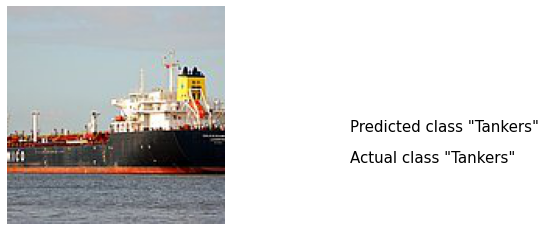

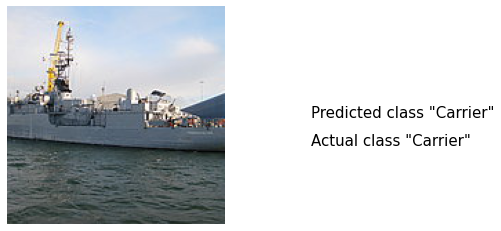

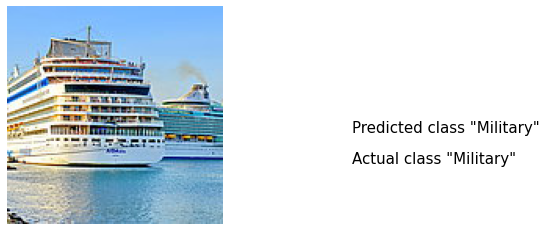

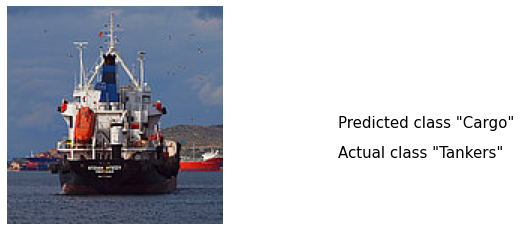

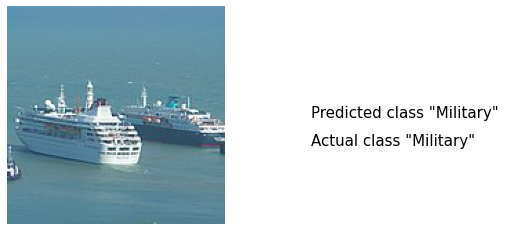

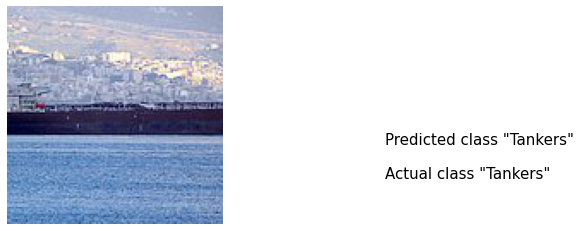

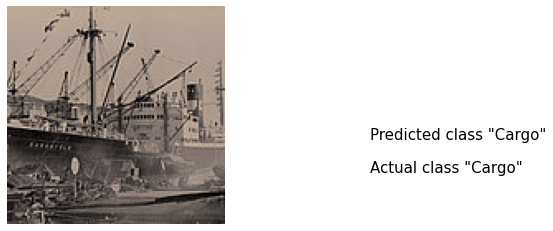

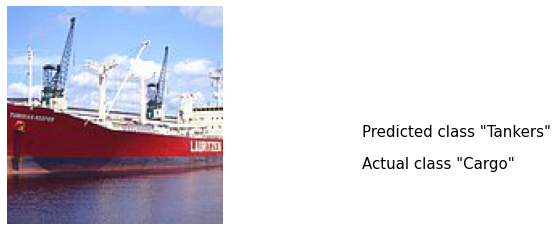

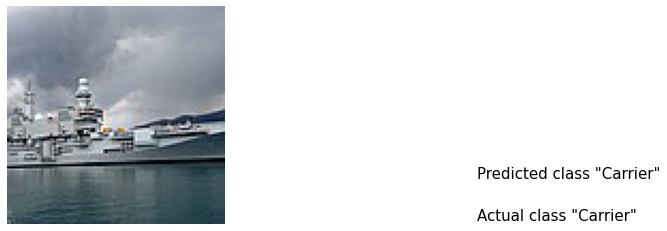

In [0]:
data_path = "../content/drive/My Drive/Colab Notebooks/Ship/train/images/"
t0 = time.time()
temp_range = range(5001,5011)
for i in temp_range:
  training_images_path = os.path.join(data_path, rcsv.iloc[i][0])
  im = plt.imread(training_images_path)
  x = image_to_input(NAS_model_logits, training_images_path)
  np_logits_pooled = NAS_model_logits.predict(x)
  np_logits_pooled = get_logits_from_non_top( np_logits_pooled )

  prediction_i = classifier.predict([ np_logits_pooled ])
  #decision     = classifier.decision_function([ np_logits_pooled ])

  plt.figure()
  im = crop_middle_square_area(im)
  plt.imshow(im.astype('uint8'))
  plt.axis('off')

  prediction = Category[ prediction_i[0] ]
  actual_class = Category[rcsv.iloc[i][1]]
  
  plt.text(220, 80, 'Predicted class "{}"'.format(prediction), fontsize=15)
  plt.text(220, 100, 'Actual class "{}"'.format(actual_class), fontsize=15)
#  plt.text(2*320, 50, '{} : Distance from boundary = {:5.2f}'.format(prediction, decision[0]), fontsize=20)
print("DONE : %6.2f seconds each" %(float(time.time() - t0)/len(temp_range),))

In [0]:
count=0
for i in range(5012,5252):
  training_images_path = os.path.join(data_path, rcsv.iloc[i][0])
  im = plt.imread(training_images_path)
  x = image_to_input(NAS_model_logits, training_images_path)
  np_logits_pooled = NAS_model_logits.predict(x)
  np_logits_pooled = get_logits_from_non_top( np_logits_pooled )

  prediction_i = classifier.predict([ np_logits_pooled ])
  decision     = classifier.decision_function([ np_logits_pooled ])
  if Category[ prediction_i[0] ] == Category[rcsv.iloc[i][1]]:
    count=count+1
percent=(count/len(range(5012,5252)))*100

print("Accuracy of NASNet : %6.2f percent" %(percent))

count=0
for i in range(5012,5252):
  training_images_path = os.path.join(data_path, rcsv.iloc[i][0])
  im = plt.imread(training_images_path)
  x = image_to_input(model_IncepV3, training_images_path)
  np_logits_pooled2 = Incep3_model_logits.predict(x)
  np_logits_pooled2 = get_logits_from_non_top( np_logits_pooled2 )

  prediction_i = classifier2.predict([ np_logits_pooled2 ])
  decision     = classifier2.decision_function([ np_logits_pooled2 ])
  if Category[ prediction_i[0] ] == Category[rcsv.iloc[i][1]]:
    count=count+1
percent=(count/len(range(5012,5252)))*100

print("Accuracy of Inception V3 : %6.2f percent" %(percent))

count=0
for i in range(5012,5252):
  training_images_path = os.path.join(data_path, rcsv.iloc[i][0])
  im = plt.imread(training_images_path)
  x = image_to_input(model_IncepResnet, training_images_path)
  np_logits_pooled3 = IncepRes_model_logits.predict(x)
  np_logits_pooled3 = get_logits_from_non_top( np_logits_pooled3 )

  prediction_i = classifier3.predict([ np_logits_pooled3 ])
  decision     = classifier3.decision_function([ np_logits_pooled3 ])
  if Category[ prediction_i[0] ] == Category[rcsv.iloc[i][1]]:
    count=count+1
percent=(count/len(range(5012,5252)))*100

print("Accuracy of Inception ResNet : %6.2f percent" %(percent))

Accuracy of NASNet :  82.08 percent
Accuracy of Inception V3 :  87.08 percent
Accuracy of Inception ResNet :  84.58 percent
